P1 comme machine

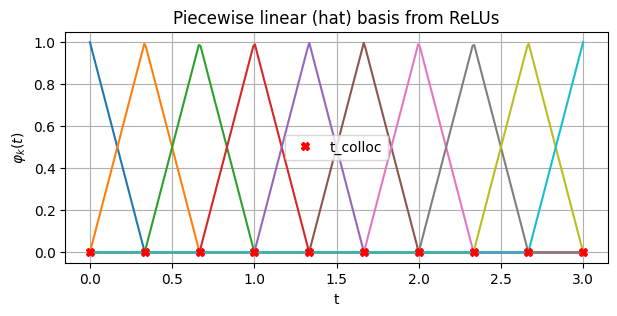

In [68]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

class S1:
    def __init__(self, t_mesh):
        n = len(t_mesh)+2 
        self.t = jnp.zeros(shape=(n))
        # jnp est un peu plus compliqué que numpy...            
        self.t = self.t.at[1:-1].set(t_mesh)
        self.t = self.t.at[0].set(t_mesh[0] - (t_mesh[1] - t_mesh[0]))
        self.t = self.t.at[-1].set(t_mesh[-1] + (t_mesh[-1] - t_mesh[-2]))
        dtinv = 1.0/(self.t[1:] - self.t[:-1])
        self.W = jnp.ones(n)
        self.b = -self.t       
        self.alpha = dtinv[1:]
        self.gamma = dtinv[:-1]
        self.beta = -self.alpha - self.gamma
    def bases(self, t):
        t = jnp.atleast_1d(t)
        # shape (n, len(t))
        y = jnp.maximum(0.0, self.W[:, None] * t[None, :] + self.b[:, None])
        phi = (
        self.alpha[:, None] * y[2:, :]
        + self.beta[:, None] * y[1:-1, :]
        + self.gamma[:, None] * y[:-2, :]
        )
        return phi
    def forward(self, params, t):
        t = jnp.atleast_1d(t)
        return jnp.dot(params, self.bases(t))

# Points de collocation
t0, t1, n_colloc = 0.0, 3.0, 10
t_colloc = jnp.linspace(t0, t1, n_colloc)
s1 = S1(t_colloc)

t_plot = jnp.linspace(t0, t1, 300)
phi = np.asarray(s1.bases(t_plot))  # (n-2, len(t))

plt.figure(figsize=(7,3))
plt.plot(t_plot, phi.T)
plt.plot(np.asarray(t_colloc), np.zeros_like(np.asarray(t_colloc)), 'Xr', label='t_colloc')
plt.title("Piecewise linear (hat) basis from ReLUs")
plt.xlabel("t")
plt.ylabel(r"$\varphi_k(t)$")
plt.grid(True)
plt.legend()
plt.show()

Epoch       0, Loss: 4.500e-01
Epoch      10, Loss: 3.081e-02
Epoch      20, Loss: 1.991e-03
Epoch      30, Loss: 1.286e-04
Epoch      40, Loss: 8.311e-06
Epoch      50, Loss: 5.370e-07
Epoch      60, Loss: 3.469e-08
Epoch      70, Loss: 2.240e-09
Epoch      80, Loss: 9.655e-10
Epoch      90, Loss: 9.370e-10


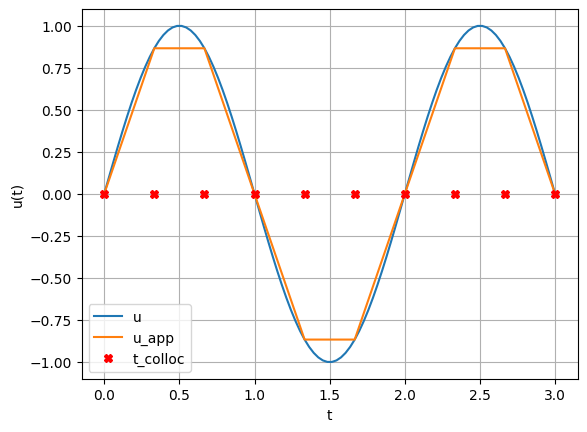

In [72]:
import optax

t0, t1, n_colloc = 0, 3, 10
t_colloc = np.linspace(t0, t1, n_colloc)
s1 = S1(t_colloc)

def u(t):
    return np.sin(np.pi * t)

data = (t_colloc, u(t_colloc))

def loss(params):
    res = data[1] - s1.forward(params,data[0])
    return jnp.mean(res ** 2)
 
params = jnp.zeros(shape=(s1.alpha.shape[0]))
optimizer = optax.lbfgs(learning_rate=0.001)
opt_state = optimizer.init(params)
@jax.jit
def train_step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss)(params)
    updates, opt_state = optimizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, grads, updates

n_epochs = 100
for epoch in range(n_epochs):
    params, opt_state, loss_value, grads, updates = train_step(params, opt_state)
    if epoch % 10== 0:
        print(f"Epoch {epoch:7d}, Loss: {loss_value:.3e}")

t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label='u')
plt.plot(t_plot, np.array(s1.forward(params, t_plot)), label='u_app')
plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()


Même chose, mais avec des points de la machine différents de la collocation.

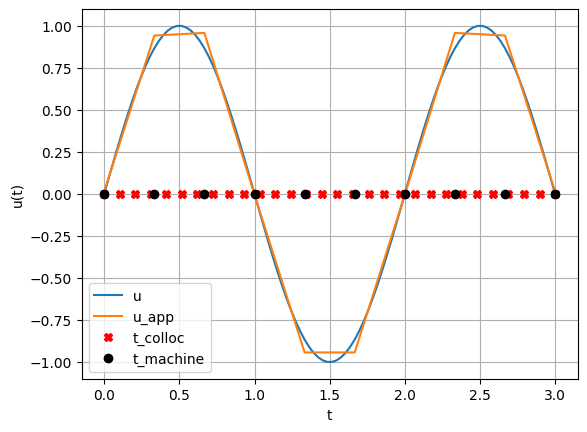

In [89]:
import jaxopt

t0, t1, n_colloc, n_machine = 0, 3, 30, 10
t_colloc = np.linspace(t0, t1, n_colloc)
t_machine= np.linspace(t0, t1, n_machine)
s1 = S1(t_machine)

def u(t):
    return np.sin(np.pi * t)

data = (t_colloc, u(t_colloc))

def loss(params):
    res = data[1] - s1.forward(params,data[0])
    return jnp.mean(res ** 2)
 
params = jnp.zeros(shape=(s1.alpha.shape[0]))
solver = jaxopt.LBFGS(fun=loss, maxiter=200, tol=1e-6)
res = solver.run(params)
params = res.params

t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label='u')
plt.plot(t_plot, np.array(s1.forward(params, t_plot)), label='u_app')
plt.plot(t_colloc, np.zeros_like(t_colloc), 'Xr', label='t_colloc')
plt.plot(t_machine, np.zeros_like(t_machine), 'ok', label='t_machine')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()


Final Loss: 2.3018782e-05
Optimized weights: [-0.05080068  0.25260466  0.4547968   0.73888123  0.94968265  1.0145231
  0.86648405  0.5997104   0.3940135   0.18754897 -0.11978252 -0.36988747
 -0.53297424 -0.7993212  -0.986802   -0.98683906 -0.79943424 -0.5330306
 -0.37004742 -0.12043218  0.1877306   0.3937263   0.6003412   0.8665037
  1.0145267   0.94967496  0.7384957   0.45562196  0.2518225  -0.0508935 ]
Optimized machine points: [-0.01641105  0.08100172  0.38495472  0.14917877  0.2605247   0.52956766
  0.7974752   0.8714178   1.0379611   1.2897224   0.9402176   0.6746865
  1.1203294   1.1775063   1.4202335   1.5797242   1.8224758   1.8796077
  2.3253105   2.0598404   1.7102213   1.9618258   2.1284735   2.2027907
  2.470526    2.7396452   2.8504899   2.615071    2.9192653   3.016429  ]


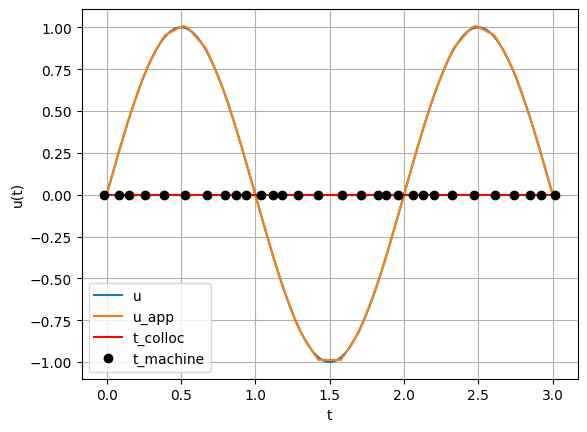

In [110]:
import jaxopt

t0, t1, n_colloc, n_machine = 0, 3, 100, 30
t_colloc = np.linspace(t0, t1, n_colloc)

def u(t):
    return np.sin(np.pi * t)

def relu_hat_basis(t, t_machine):
    t_machine = jnp.sort(t_machine)
    n_machine = len(t_machine)

    # Ghost points
    t_left = t_machine[0] - (t_machine[1]-t_machine[0])
    t_right = t_machine[-1] + (t_machine[-1]-t_machine[-2])
    t_full = jnp.concatenate([jnp.array([t_left]), t_machine, jnp.array([t_right])])

    dt = t_full[1:] - t_full[:-1]
    dtinv = 1.0 / dt

    # Make alpha, beta, gamma exactly length n_machine
    alpha = dtinv[1:1+n_machine]   # slice of length 10
    gamma = dtinv[0:n_machine]     # slice of length 10
    beta = -alpha - gamma

    W = jnp.ones(len(t_full))
    b = -t_full

    y = jnp.maximum(0.0, W[:, None] * t[None,:] + b[:, None])

    # Now all slices have length n_machine
    phi = alpha[:, None] * y[2:2+n_machine,:] \
        + beta[:, None] * y[1:1+n_machine,:] \
        + gamma[:, None] * y[0:0+n_machine,:]

    return phi   # shape (n_machine, len(t))    
def model(params, t):
    phi = relu_hat_basis(t, params["t_machine"])   # (n_machine, n_points)
    return jnp.dot(params["weights"], phi)

def loss(params):
    res = model(params, t_colloc) - u(t_colloc)
    return jnp.mean(res**2)

params = {
    "weights": jnp.zeros(n_machine),
    "t_machine": jnp.linspace(0, 3, n_machine)     # trainable mesh!
}

solver = jaxopt.LBFGS(fun=loss, maxiter=200, tol=1e-8)
res = solver.run(params)
params = res.params
print("Final Loss:", res.state.value)
print("Optimized weights:", params["weights"])
print("Optimized machine points:", params["t_machine"])


t_plot = np.linspace(t0, t1, 100)
plt.plot(t_plot, u(t_plot), label='u')
plt.plot(t_plot, np.array(model(params, t_plot)), label='u_app')
plt.plot(t_colloc, np.zeros_like(t_colloc), '-r', label='t_colloc')
plt.plot( params["t_machine"], np.zeros_like( params["t_machine"]), 'ok', label='t_machine')
plt.legend()
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True)
plt.show()
